# Import Packages

In [419]:
# Import packages
import random
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from scipy.stats import beta, f_oneway, kruskal

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [420]:
num_algorithms = 3
num_trials = 100
rewards = np.random.normal(size=(num_algorithms, num_trials))

# calculate the mean reward for each algorithm
mean_rewards = np.mean(rewards, axis=1)

# calculate the ANOVA test statistic and p-value
f, p = f_oneway(*rewards)

print("Mean rewards for each algorithm:")
for i, mean_reward in enumerate(mean_rewards):
    print(f"Algorithm {i}: {mean_reward:.2f}")

print(f"ANOVA test statistic: {f:.2f}")
print(f"P-value: {p:.4f}")

Mean rewards for each algorithm:
Algorithm 0: 0.09
Algorithm 1: -0.02
Algorithm 2: -0.05
ANOVA test statistic: 0.52
P-value: 0.5948


In [421]:
rewards

array([[ 1.19162140e-01, -1.37238780e-01, -1.00766009e+00,
         3.18089039e+00, -3.12914520e-01, -5.15875523e-01,
         2.84609897e-01,  3.18708446e-01, -6.28097015e-01,
        -1.03699559e+00, -1.23148081e+00,  4.16113814e-01,
         6.03575869e-02, -3.27820019e-01,  2.30437603e-01,
         4.07979315e-01,  2.08881385e-01, -5.60356974e-01,
        -2.20834017e-01,  8.92943074e-01, -7.96511953e-01,
        -1.11945901e+00,  6.18275701e-01,  8.09115398e-01,
        -8.59565260e-01,  5.52275517e-02,  1.33900619e+00,
         2.03799186e-01,  2.19667808e+00,  1.05626745e+00,
        -1.33435397e+00, -6.00722509e-01,  6.98526052e-01,
        -8.08147866e-01,  1.03106115e+00,  1.06127587e+00,
        -2.22239662e-01, -1.43342803e+00, -8.68621048e-01,
        -1.48804143e+00,  2.19880291e-01,  2.66563811e-01,
        -4.11650967e-01,  1.93141262e+00,  2.77245751e+00,
        -3.02789003e-01, -4.17708694e-01, -1.12448318e+00,
         3.92333786e-01, -1.48798916e+00, -3.77670936e-0

# Algorithms 
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [422]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [423]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)

    z = sum([np.exp(v / temp) for v in history["mean"]])
    pi = [np.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1 (CHECK)

In [424]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values)) + 1
    
    return chosen_arm

### Bayesian UCB (CHECK)

In [425]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3) + 1
    
    return chosen_arm

### Thompson Sampling (CHECK)

In [426]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x]) + 1
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy (CHECK)

In [427]:
def epsilon_greedy(history, arms, epsilon):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return chosen_arm

### Softmax

In [428]:
def softmax(history, arms, temp):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### LinUCB

In [429]:
def linucb(history, arms, context, alpha = 0.5):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        A_inv = np.linalg.inv(history['A'][arm])
        theta = A_inv @ history['b'][arm]
        p_arm = theta.T @ context[arm] + alpha * np.sqrt(context[arm].T @ A_inv @ context[arm])
        scores[arm] = p_arm
        thetas[arm] = theta
    return np.argmax(scores)

# def recommend(self, context):
#     scores = np.zeros(self.n_arms)
#     thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
#     for arm in range(self.n_arms):
#         A_inv = np.linalg.inv(self.A[arm])
#         theta = A_inv @ self.b[arm]
#         p_arm = theta.T @ context + self.alpha * np.sqrt(context.T @ A_inv @ context)
#         scores[arm] = p_arm
#         thetas[arm] = theta
#     return np.argmax(scores), thetas, scores

# # context
# np.array([np.random.uniform(low = 0, high = 1, size = 5)])

# def update(self, arm, context, reward):
#     self.A[arm] += np.outer(context, contxt)
#     self.b[arm] += reward * context

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [430]:
# logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT)
0,M,YOUNG,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,0.301196
1,F,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196
2,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,0.419251
3,M,YOUNG,Y,L,N,N,Y,L,4,Alive,Alive and recovered,1,0.274168
4,M,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,M,YOUNG,N,L,N,N,N,L,2,Alive,Alive and recovered,1,0.274168
2496,F,YOUNG,N,L,N,N,Y,L,2,Alive,Alive and recovered,1,0.274168
2497,F,OLD,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,0.274168
2498,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0.419251


In [431]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(5):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [432]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)
arms

array([1, 4, 3, 2], dtype=int64)

## Bernoulli Arm

In [433]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [epsilon_decay, annealing_softmax, ucb1, bayesian_ucb, thompson_sampling, epsilon_greedy, softmax, linucb]
# algos = [linucb]

# Define a dataframe for evaluation results
evaluation = []

# Define a list to save all arm-play statistics
play_stats = []

# Check algos
count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b]
        
        step = 0

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 6:
                rec_a = f(container, arms)
            elif count_algos == 8:
                # Context (for LinUCB) --> size = n_features
                context = np.array([np.random.uniform(low = 0, high = 1, size = 2) for _ in np.arange(len(arms))])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)

            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (BER)'] # get the reward value
                regret = 1 - reward
                context_arm = context[action - 1] 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation.append(eva_rec)
                
                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 8:
                    container['A'][action] = container['A'][action] + np.outer(context_arm, context_arm)
                    container['b'][action] = container['b'][action] + reward * context_arm
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [434]:
evaluation = pd.DataFrame(evaluation)
evaluation = evaluation.sort_values(by=['policy','time_step'])
evaluation

,policy,chosen_arm,time_step,sex,age,reward,regret
16479,annealing_softmax,3,1,M,YOUNG,1,0
19368,annealing_softmax,4,1,M,OLD,1,0
21700,annealing_softmax,4,1,F,OLD,0,1
24971,annealing_softmax,3,1,M,OLD,1,0
28286,annealing_softmax,3,1,M,YOUNG,1,0
...,...,...,...,...,...,...,...
40086,ucb1,2,1802,F,OLD,0,1
40087,ucb1,2,1803,M,YOUNG,1,0
40088,ucb1,2,1804,F,OLD,0,1
40089,ucb1,2,1805,F,OLD,1,0


In [435]:
evaluation[(evaluation["time_step"] == 1) | (evaluation["time_step"] == 2)]

,policy,chosen_arm,time_step,sex,age,reward,regret
16479,annealing_softmax,3,1,M,YOUNG,1,0
19368,annealing_softmax,4,1,M,OLD,1,0
21700,annealing_softmax,4,1,F,OLD,0,1
24971,annealing_softmax,3,1,M,OLD,1,0
28286,annealing_softmax,3,1,M,YOUNG,1,0
...,...,...,...,...,...,...,...
31556,ucb1,4,2,F,OLD,1,0
33297,ucb1,4,2,M,OLD,1,0
35073,ucb1,4,2,F,OLD,0,1
36699,ucb1,4,2,M,OLD,0,1


In [436]:
final_evaluation = evaluation.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                            "regret":"mean"})

final_evaluation['cumulative_reward'] = final_evaluation.groupby(['policy'])['reward'].cumsum()
final_evaluation['cumulative_regret'] = final_evaluation.groupby(['policy'])['regret'].cumsum()
final_evaluation

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.8,0.2,0.80,0.20
1,annealing_softmax,2,0.6,0.4,1.40,0.60
2,annealing_softmax,3,1.0,0.0,2.40,0.60
3,annealing_softmax,4,0.6,0.4,3.00,1.00
4,annealing_softmax,5,1.0,0.0,4.00,1.00
...,...,...,...,...,...,...
22627,ucb1,1802,0.0,1.0,1389.35,412.65
22628,ucb1,1803,1.0,0.0,1390.35,412.65
22629,ucb1,1804,0.0,1.0,1390.35,413.65
22630,ucb1,1805,1.0,0.0,1391.35,413.65


## Test Stats

In [441]:
epsilon_greedy_rewards = list(final_evaluation[final_evaluation['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation[final_evaluation['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation[final_evaluation['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation[final_evaluation['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation[final_evaluation['policy'] == 'ucb1']['reward'])
bayes_ucb_rewards = list(final_evaluation[final_evaluation['policy'] == 'bayesian_ucb']['reward'])
thompson_rewards = list(final_evaluation[final_evaluation['policy'] == 'thompson_sampling']['reward'])
linucb_rewards = list(final_evaluation[final_evaluation['policy'] == 'linucb']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards)

F_onewayResult(statistic=2.416436429525447, pvalue=0.017981814764612723)

## Reward
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

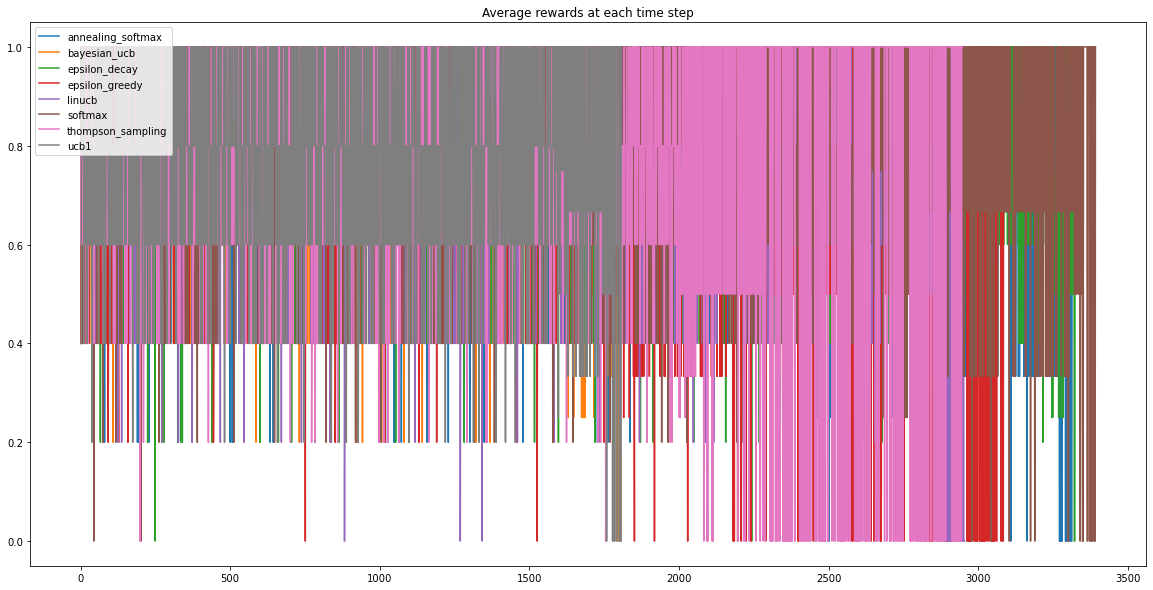

In [438]:
# Plot the rewards at each time step
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation['policy'].unique():
    results_policy = final_evaluation[final_evaluation['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

In [439]:
# Determine the cumulative reward at 1000 time step
final_evaluation.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"})

,policy,cumulative_reward
0,annealing_softmax,2563.433333
1,bayesian_ucb,1369.233333
2,epsilon_decay,2584.350000
3,epsilon_greedy,2393.900000
4,linucb,2272.366667
5,softmax,2621.200000
6,thompson_sampling,2241.200000
7,ucb1,1391.350000


Text(0.5, 1.0, 'Cumulative rewards at each step')

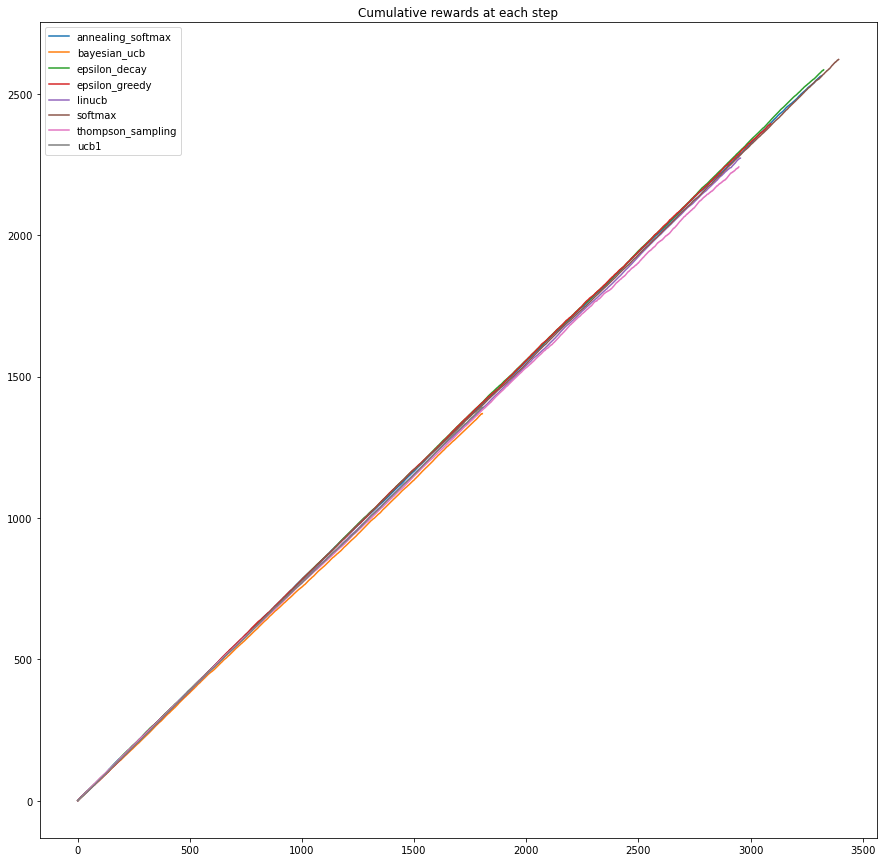

In [440]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation['policy'].unique():
    results_policy = final_evaluation[final_evaluation['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
plt.legend()
plt.title("Cumulative rewards at each step")

## Categorical Arm

In [446]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [epsilon_decay, annealing_softmax, ucb1, epsilon_greedy, softmax, linucb]
# algos = [annealing_softmax]

# Define a dataframe for evaluation results
evaluation = []

# Define a list to save all arm-play statistics
play_stats = []

count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b]
        
        step = 0

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 4:
                rec_a = f(container, arms)
            elif count_algos == 6:
                # Context (for LinUCB) --> size = n_features
                context = np.array([np.random.uniform(low = 0, high = 1, size = 2) for _ in np.arange(len(arms))])
                rec_a = f(container, arms, context)
            elif count_algos == 4:
                rec_a = f(container, arms, 0.2)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (CAT)'] # get the reward value
                regret = 1 - reward
                context_arm = context[action - 1] 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation.append(eva_rec)

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 6:
                    container['A'][action] = container['A'][action] + np.outer(context_arm, context_arm)
                    container['b'][action] = container['b'][action] + reward * context_arm
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [447]:
evaluation = pd.DataFrame(evaluation)
evaluation = evaluation.sort_values(by=['policy','time_step'])
evaluation

,policy,chosen_arm,time_step,sex,age,reward,regret
13509,annealing_softmax,3,1,F,OLD,0.301196,0.698804
15778,annealing_softmax,1,1,M,YOUNG,0.301196,0.698804
17939,annealing_softmax,3,1,F,OLD,0.301196,0.698804
20018,annealing_softmax,3,1,M,OLD,0.419251,0.580749
21936,annealing_softmax,1,1,F,OLD,0.301196,0.698804
...,...,...,...,...,...,...,...
32769,ucb1,2,1798,F,OLD,0.419251,0.580749
32770,ucb1,2,1799,M,YOUNG,0.301196,0.698804
32771,ucb1,2,1800,F,OLD,0.419251,0.580749
32772,ucb1,2,1801,F,OLD,0.274168,0.725832


In [448]:
final_evaluation = evaluation.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                            "regret":"mean"})

final_evaluation['cumulative_reward'] = final_evaluation.groupby(['policy'])['reward'].cumsum()
final_evaluation['cumulative_regret'] = final_evaluation.groupby(['policy'])['regret'].cumsum()
final_evaluation

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.324807,0.675193,0.324807,0.675193
1,annealing_softmax,2,0.290385,0.709615,0.615192,1.384808
2,annealing_softmax,3,0.337607,0.662393,0.952799,2.047201
3,annealing_softmax,4,0.290385,0.709615,1.243183,2.756817
4,annealing_softmax,5,0.343012,0.656988,1.586196,3.413804
...,...,...,...,...,...,...
13985,ucb1,1798,0.419251,0.580749,578.218195,1219.781805
13986,ucb1,1799,0.301196,0.698804,578.519391,1220.480609
13987,ucb1,1800,0.419251,0.580749,578.938642,1221.061358
13988,ucb1,1801,0.274168,0.725832,579.212810,1221.787190


In [449]:
epsilon_greedy_rewards = list(final_evaluation[final_evaluation['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation[final_evaluation['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation[final_evaluation['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation[final_evaluation['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation[final_evaluation['policy'] == 'ucb1']['reward'])
linucb_rewards = list(final_evaluation[final_evaluation['policy'] == 'linucb']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, linucb_rewards)

F_onewayResult(statistic=7.652661131884223, pvalue=3.4157445108775124e-07)

## Reward

Text(0.5, 1.0, 'Average rewards at each time step')

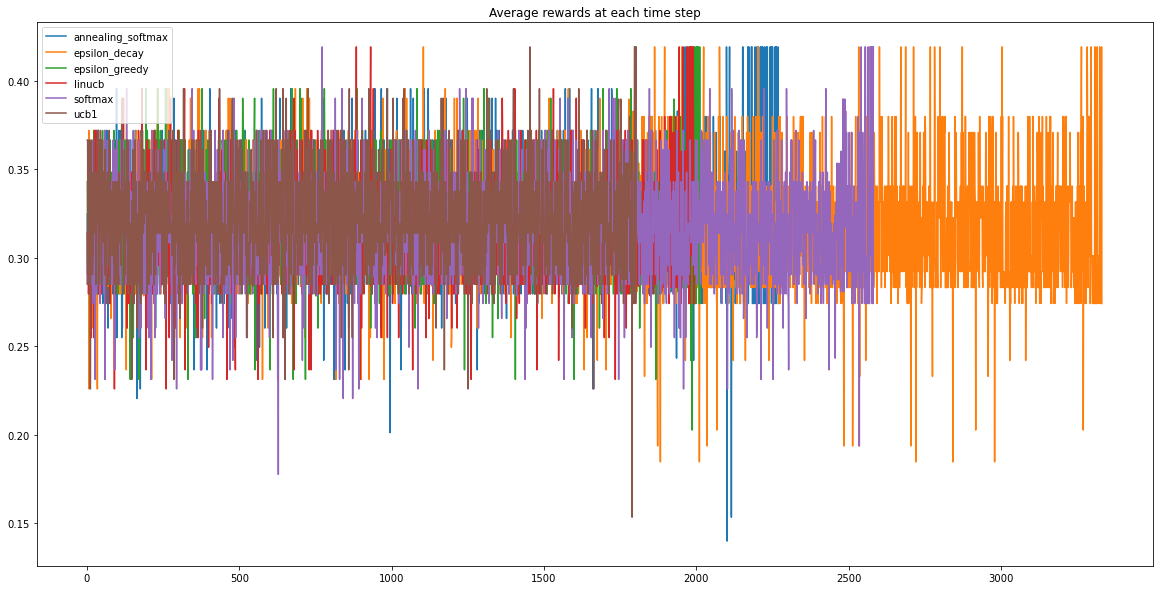

In [450]:
# Plot the rewards at each time step
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation['policy'].unique():
    results_policy = final_evaluation[final_evaluation['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

In [451]:
# Determine the cumulative reward at 1000 time step
final_evaluation.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"})

,policy,cumulative_reward
0,annealing_softmax,722.804526
1,epsilon_decay,1058.606850
2,epsilon_greedy,643.120573
3,linucb,633.709263
4,softmax,816.921080
5,ucb1,579.632061


Text(0.5, 1.0, 'Cumulative rewards at each step')

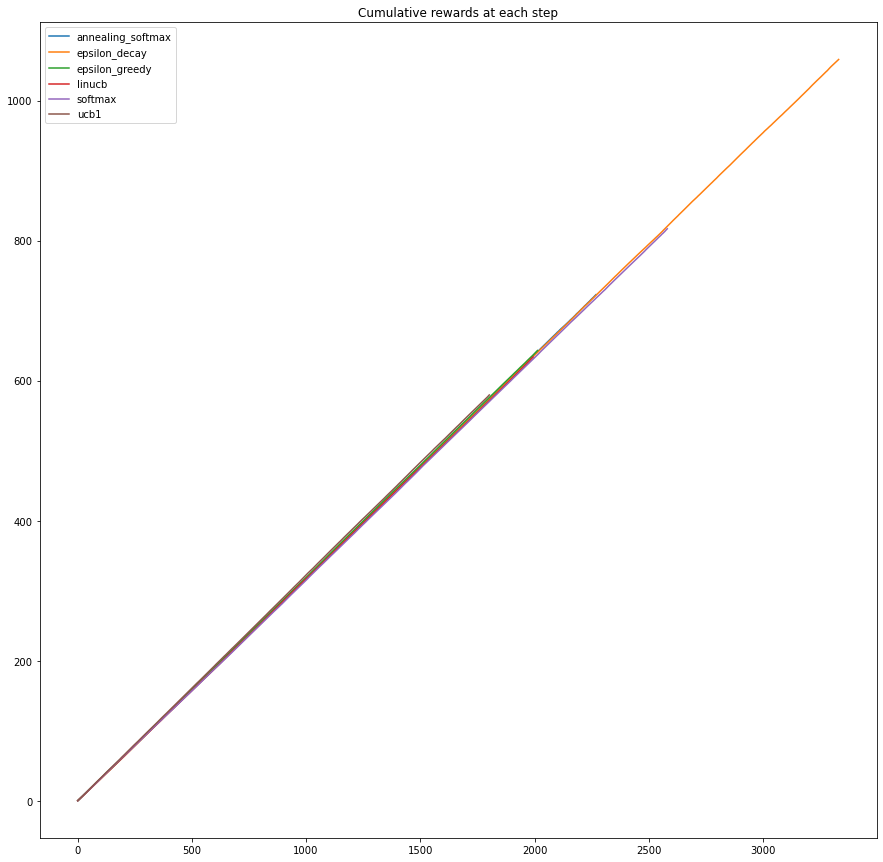

In [452]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation['policy'].unique():
    results_policy = final_evaluation[final_evaluation['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
plt.legend()
plt.title("Cumulative rewards at each step")